## Machine Translation (Dutch-English)

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# reading data files and building index2word, word2index and wordcount to keep track of all words with the helper class Lang

SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
# Turn a Unicode string to plain ASCII by lowering all words to lowercase and trimming most puncutations.

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
#Reading data files by splitting into lines and lines into pairs. Reverse parameter can be used to reverse the translation.

def readLangs(lang1, lang2, reverse= False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [12]:
#PrepareData function reads text file, splits into lines and line into pairs

def prepareData(lang1, lang2, reverse= False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'dch', True)
print(random.choice(pairs))

Reading lines...
Read 28547 sentence pairs
Trimmed to 1981 sentence pairs
Counting words...
Counted words:
dch 1424
eng 1248
['wij zijn bij je .', 'we are with you .']


In [0]:
#RNN encoder outputs some value for every word from the input value
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
#RNN decoder takes the output vectors from encoder and ouputs a sequence of words to create the translation.

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
#Attention layer allows you to focus on different parts of the encoders outputs for every step of the decoders own outputs. It calculates attention weights and uses another FF network.

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
#preparing training data

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
#training the model

teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
#Creating helper function to monitor the time elapsed and remaining for training

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
#trainiters monitors starttime, initializes optimizers and criterions

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
#plotting the above array of training loses

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
#Evaluation feed the decoder's predictions back to itself for each step
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
#evaluates random pairs to make quality judgements

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [24]:
#finally using all the above functions, we evaluate and run the model

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

3m 53s (- 54m 27s) (5000 6%) 2.6624
7m 57s (- 51m 45s) (10000 13%) 1.7611
12m 0s (- 48m 3s) (15000 20%) 1.1004
16m 2s (- 44m 7s) (20000 26%) 0.6730
20m 9s (- 40m 19s) (25000 33%) 0.3805
24m 18s (- 36m 27s) (30000 40%) 0.2443
28m 21s (- 32m 24s) (35000 46%) 0.1778
32m 14s (- 28m 13s) (40000 53%) 0.1385
36m 11s (- 24m 7s) (45000 60%) 0.1230
40m 12s (- 20m 6s) (50000 66%) 0.1196
44m 14s (- 16m 5s) (55000 73%) 0.1117
48m 7s (- 12m 1s) (60000 80%) 0.1127
52m 11s (- 8m 1s) (65000 86%) 0.1029
56m 20s (- 4m 1s) (70000 93%) 0.0959
60m 24s (- 0m 0s) (75000 100%) 0.0973


In [25]:
evaluateRandomly(encoder1, attn_decoder1)

> ze is een goed zwemster .
= she is a good swimmer .
< she is a good swimmer . <EOS>

> ik eet een banaan .
= i am eating a banana .
< i m eating a banana . <EOS>

> ik blijf in italie .
= i m staying in italy .
< i m staying in italy . <EOS>

> ik ben het ruzien moe .
= i m tired of arguing .
< i m tired of arguing . <EOS>

> als ze ons vinden zijn we er geweest .
= we re dead if they find us .
< we re dead if they find us . <EOS>

> hij is wat wij een wandelend woordenboek noemen .
= he is what we call a walking dictionary .
< he is what we call a walking dictionary . <EOS>

> ze lopen op blote voeten .
= they are walking barefoot .
< they are walking barefoot . <EOS>

> je doet het verkeerd .
= you re doing it the wrong way .
< you re doing it the wrong way . <EOS>

> ik ben niet trots op mijn gedrag .
= i m not proud of my behavior .
< i m not proud of my behavior . <EOS>

> ik ben erg gevaarlijk .
= i am very dangerous .
< i am very dangerous . <EOS>



In [27]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "jullie hebben gewonnen .")
plt.matshow(attentions.numpy())

In [30]:
#creating functions to plot and evaluate the attention encoder better

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)




input = jullie hebben gewonnen .
output = you re welcome . <EOS>


In [0]:
%matplotlib inline
plt.close('all')

input = ik ben heel .
output = i m very . <EOS>


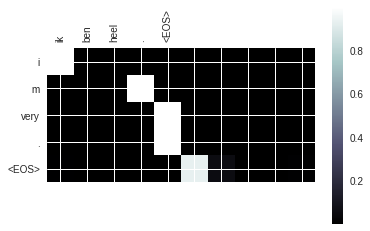

input = ik maak maar een grapje .
output = i m kidding . <EOS>


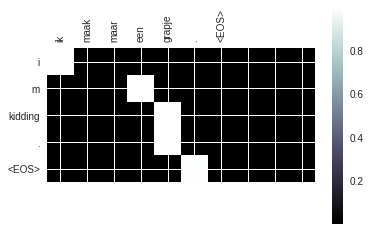

input = ik ben professor .
output = i am a professor . <EOS>


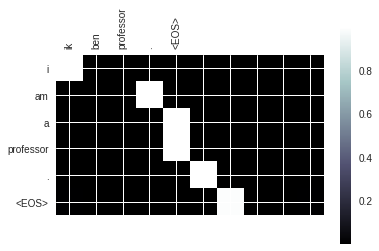

input = ik ben aan het koken .
output = i am cooking now . <EOS>


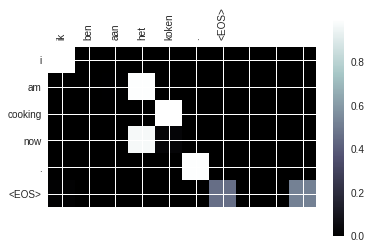

input = hij wordt ouder .
output = he s getting old . <EOS>


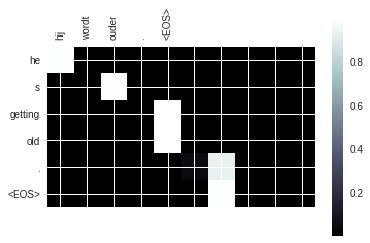

In [48]:
#Here we have given the input language dutch and the ouput is english. 

evaluateAndShowAttention('ik ben heel .')

evaluateAndShowAttention('ik maak maar een grapje .')

evaluateAndShowAttention('ik ben professor .')

evaluateAndShowAttention('ik ben aan het koken .')

evaluateAndShowAttention('hij wordt ouder .')



In [0]:
output_words, attentions = evaluate(encoder1, attn_decoder1, 'es el director d un hotel .')

In [0]:
output = ' '.join(output_words)
print(output)

he is the manager of a hotel . <EOS>


In [0]:
output_lang.word2index.keys()

dict_keys(['i', 'm', 'too', '.', 'at', 'home', 'desperate', 'am', 'now', 'on', 'duty', 'already', 'late', 'not', 'a', 'doctor', 'they', 're', 'my', 'books', 'salesperson', 'you', 'are', 'good', 'boy', 'he', 's', 'the', 'oldest', 'son', 'is', 'athlete', 'glad', 'here', 'she', 'swimmer', 'taller', 'than', 'me', 'angry', 'with', 'sure', 'of', 'his', 'success', 'talking', 'phone', 'everything', 'to', 'busy', 'so', 'can', 't', 'help', 'standing', 'in', 'shade', 'afraid', 'caught', 'cold', 'tom', 'younger', 'sister', 'child', 'anymore', 'one', 'who', 'touched', 'has', 'key', 'manager', 'hotel', 'giving', 'party', 'tonight', 'very', 'thoughtful', 'person', 'see', 'again', 'getting', 'better', 'bit', 'by', 'professional', 'photographer', 'we', 'sorry', 'for', 'inconvenience', 'going', 'change', 'anything', 'winning', 'championship', 'surprised', 'that', 'accepted', 'offer'])

### English to Dutch

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [155]:
import numpy as np
import os

os.getcwd()

'/content'

In [0]:
# Prepare Glove File
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  # map from a token (word) to a Glove embedding vector
        wordToIndex = {}  # map from a token to an index
        indexToWord = {}  # map from an index to a token 

        for line in f:
            record = line.strip().split()
            token = record[0] # take the token (word) from the text line
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) # associate the Glove embedding vector to a that token (word)

        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            Idx = idx # +1
            wordToIndex[tok] = Idx # associate an index to a token (word)
            indexToWord[Idx] = tok # associate a word to a token (word)

    return wordToIndex, indexToWord, wordToGlove

In [0]:
# Create Pretrained Embedding Weights Matrix
# max_num_words = 1000
def createPretrainedEmbeddingMatrix(wordToGlove, wordToIndex):

    vocabLen =  len(wordToIndex) 
    embDim = next(iter(wordToGlove.values())).shape[0]  

    embeddingMatrix = np.zeros((vocabLen, embDim))  # initialize with zeros
    for word, index in wordToIndex.items():

        embeddingMatrix[index, :] = wordToGlove[word] # create embedding: word index to Glove word embedding

    return vocabLen, embDim, embeddingMatrix

In [0]:
max_length = 10
wordToIndex, indexToWord, wordToGlove = readGloveFile("/content/glove.6B.100d.txt")
vocabLen, embDim, embeddingMatrix = createPretrainedEmbeddingMatrix(wordToGlove, wordToIndex)

In [0]:
#Creating embedding layer with glove weights

def create_emb_layer(embeddingMatrix, non_trainable=False):
    vocabLen, embDim = embeddingMatrix.shape
    emb_layer = nn.Embedding(vocabLen, embDim)
    emb_layer.load_state_dict({'weight': embeddingMatrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, vocabLen, embDim

In [162]:
vocabLen, embDim

(400000, 100)

In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.wordToindex = {}
        self.wordTocount = {}
        self.indexToword = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.wordToindex:
            self.wordToindex[word] = self.n_words
            self.wordTocount[word] = 1
            self.indexToword[self.n_words] = word
            self.n_words += 1
        else:
            self.wordTocount[word] += 1

In [0]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
def readLangs(lang1, lang2, reverse= False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [167]:
def prepareData(lang1, lang2, reverse= False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'dch', False)
print(random.choice(pairs))

Reading lines...
Read 28547 sentence pairs
Trimmed to 1981 sentence pairs
Counting words...
Counted words:
eng 1248
dch 1424
['they re in the garden .', 'zij zijn in de tuin .']


### Here we have included the embedding layer with the weights using the pretrained glove vectors

In [0]:
#Building RNN and AttnRNN with new embedding layers
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabLen, embDim)
        # pretrained_weight is a numpy matrix of shape (num_embeddings, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embeddingMatrix))
#         self.embedding = nn.Embedding(vocabLen, embDim)
#         self.embedding.weight = nn.Parameter(embeddingMatrix)

#         self.embedding, vocabLen, embDim = create_emb_layer(embeddingMatrix, True)
        self.gru = nn.GRU(hidden_size, hidden_size)
#         self.gru = nn.GRU(emdDim, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
MAX_LENGTH = 10

In [0]:
hidden_size = 256

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.embedding = nn.Embedding(vocabLen, embDim)
        # pretrained_weight is a numpy matrix of shape (num_embeddings, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embeddingMatrix))
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.wordToindex[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.indexToword[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [180]:
hidden_size = 100
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

7m 12s (- 100m 59s) (5000 6%) 3.3729
14m 29s (- 94m 9s) (10000 13%) 2.7841
21m 46s (- 87m 7s) (15000 20%) 2.4177
29m 4s (- 79m 56s) (20000 26%) 2.0566
36m 23s (- 72m 46s) (25000 33%) 1.7776
43m 43s (- 65m 34s) (30000 40%) 1.5331
51m 1s (- 58m 19s) (35000 46%) 1.2983
58m 22s (- 51m 4s) (40000 53%) 1.1177
65m 41s (- 43m 47s) (45000 60%) 0.9345
73m 1s (- 36m 30s) (50000 66%) 0.8139
80m 24s (- 29m 14s) (55000 73%) 0.6853
87m 44s (- 21m 56s) (60000 80%) 0.5845
95m 6s (- 14m 37s) (65000 86%) 0.5130
102m 27s (- 7m 19s) (70000 93%) 0.4200
109m 47s (- 0m 0s) (75000 100%) 0.7184


In [181]:
evaluateRandomly(encoder1, attn_decoder1)

> i m a nice guy .
= ik ben een aardige gast .
< ik ben een aardige gast . <EOS>

> i m left handed .
= ik ben linkshandig .
< ik ben linkshandig . <EOS>

> she s our teacher .
= zij is onze lerares .
< zij is onze leraar . <EOS>

> i m going to need your help .
= ik zal je hulp nodig hebben .
< ik zal voor hulp . <EOS>

> you are a mean person .
= jij bent een gemeen persoon .
< jij bent een gemeen persoon . <EOS>

> i m nothing without you .
= zonder u ben ik niets .
< zonder jou ben ik niet jou . <EOS>

> i m allergic to cats .
= ik ben allergisch voor katten .
< ik ben allergisch dat te . <EOS>

> he is afraid of making mistakes .
= hij is bang fouten te maken .
< hij is bang te te maken . <EOS>

> he is something of a scholar .
= hij is een soort geleerde .
< hij is verslaafd een drie . <EOS>

> i m a vegetarian .
= ik ben vegetarier .
< ik ben vegetarier . <EOS>



In [183]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "i m a vegetarian .")
plt.matshow(attentions.numpy())

In [0]:
%matplotlib inline
plt.close('all')

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
#     plt.close('all')
    plt.show();


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("i m very relaxed .")


input = i m very relaxed .
output = ik ben heel . . <EOS>


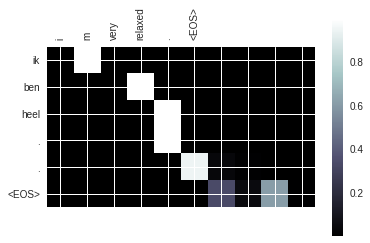

input = i m only joking .
output = ik maak maar een grapje . <EOS>


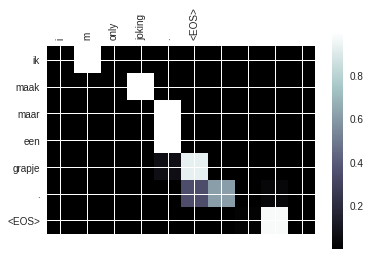

input = i m a professor .
output = ik ben professor . <EOS>


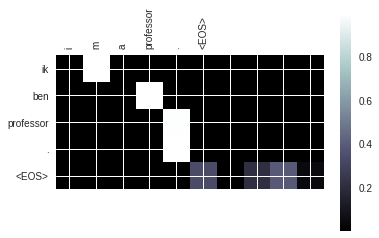

input = i m cooking now .
output = ik ben aan het koken . <EOS>


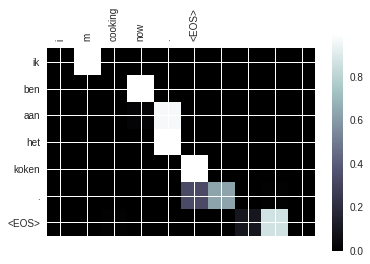

input = he s getting old .
output = hij wordt ouder . <EOS>


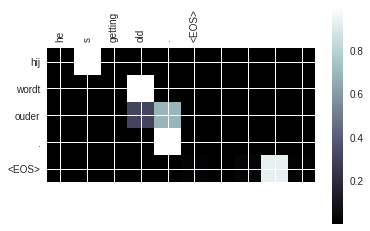

In [208]:
evaluateAndShowAttention("i am very relaxed.")

evaluateAndShowAttention("i am only joking.")

evaluateAndShowAttention("i am a professor.")

evaluateAndShowAttention("i am cooking now.")


evaluateAndShowAttention("he is getting old.")